In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + './data/UCI HAR Dataset/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + './data/UCI HAR Dataset/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape


C:\Users\luili\AppData\Local\Temp\ipykernel_21260\2740303476.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
C:\Users\luili\AppData\Local\Temp\ipykernel_21260\2740303476.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
C:\Users\luili\AppData\Local\Temp\ipykernel_21260\2740303476.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
C:\Users\luili\AppData\Local\Temp\ipykernel_21260\2740303476.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be rem

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [2]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D

# Positional Encoding 레이어
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        
        # 사전 계산된 positional encoding
        position = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        
        pos_encoding = np.zeros((max_len, d_model))
        pos_encoding[:, 0::2] = np.sin(position * div_term)
        pos_encoding[:, 1::2] = np.cos(position * div_term)
        pos_encoding = pos_encoding[np.newaxis, :, :]
        
        self.pos_encoding = tf.constant(pos_encoding, dtype=tf.float32)
        
    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:, :seq_len, :]

# Transformer Encoder Block
def transformer_encoder_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head Self-Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs
    
    # Feed Forward Network
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    return x + res

# Transformer 모델 구성
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0.1, mlp_dropout=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    
    # Embedding
    x = Dense(head_size * num_heads)(x)
    x = PositionalEncoding(head_size * num_heads)(x)
    
    # Transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder_block(x, head_size, num_heads, ff_dim, dropout)
    
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    
    # MLP
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    
    outputs = Dense(n_outputs, activation="softmax")(x)
    return Model(inputs, outputs)

# 모델 하이퍼파라미터 설정
head_size = 64
num_heads = 4
ff_dim = 256
num_transformer_blocks = 4
mlp_units = [128, 64]
dropout = 0.1
mlp_dropout = 0.1

# 모델 생성
transformer_model = build_transformer_model(
    input_shape=(n_timesteps, n_features),
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=mlp_units,
    dropout=dropout,
    mlp_dropout=mlp_dropout
)

transformer_model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

transformer_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128, 256)  │      2,560 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 128, 256)  │          0 │ dense[0][0]       │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128, 256)  │        512 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 256)  │    263,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 256)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 256)  │          0 │ dropout_1[0][0],  │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 256)  │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128, 256)  │     65,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 256)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128, 256)  │     65,792 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128, 256)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 256)  │          0 │ dropout_3[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 256)  │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 256)  │    263,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128, 256)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 256)  │          0 │ dropout_5[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 256)  │        512 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128, 256)  │     65,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,627,206 (6.21 MB)

 Trainable params: 1,627,206 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Early stopping callback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
]

model_history = transformer_model.fit(
    X_train, y_train_one_hot,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.4705 - loss: 1.2542 - val_accuracy: 0.5976 - val_loss: 0.7765 - learning_rate: 0.0010
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 47s 257ms/step - accuracy: 0.6946 - loss: 0.6634 - val_accuracy: 0.7220 - val_loss: 0.5514 - learning_rate: 0.0010
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 149s 623ms/step - accuracy: 0.7757 - loss: 0.4961 - val_accuracy: 0.7634 - val_loss: 0.4401 - learning_rate: 0.0010
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 115s 624ms/step - accuracy: 0.8492 - loss: 0.3806 - val_accuracy: 0.8416 - val_loss: 0.4268 - learning_rate: 0.0010
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 82s 445ms/step - accuracy: 0.8883 - loss: 0.2947 - val_accuracy: 0.8810 - val_loss: 0.3090 - learning_rate: 0.0010
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 113s 617ms/step - accuracy: 0.9065 - loss: 0.2337 - val_accuracy: 0.8491 - val_loss: 0.4172 - learning_rate: 0.0010
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 216ms/step - accuracy: 

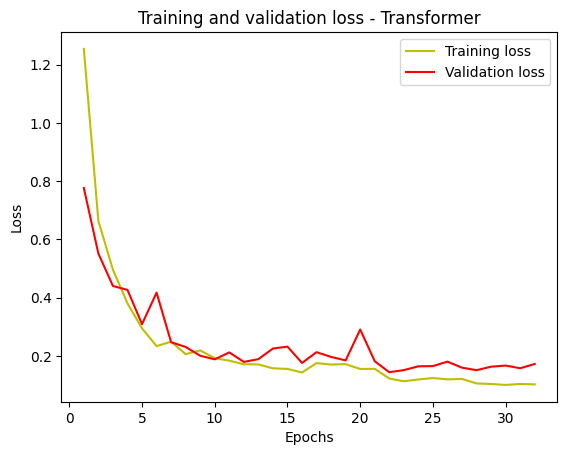

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss - Transformer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


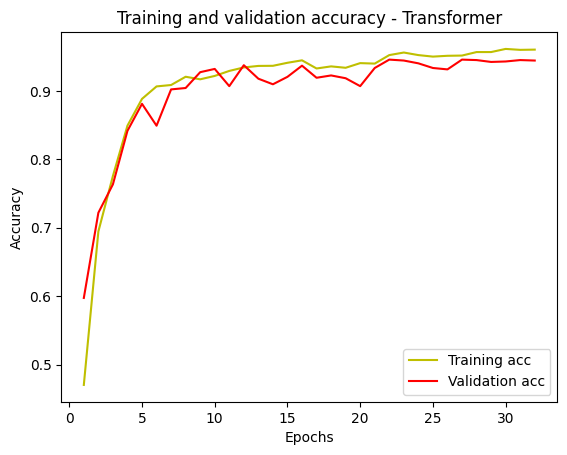

In [6]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy - Transformer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step
Confusion Matrix:
[[405  25  66   0   0   0]
 [ 37 412  22   0   0   0]
 [ 18  12 390   0   0   0]
 [  0   1   0 417  73   0]
 [  0   0   0 109 423   0]
 [  0   0   0   0   0 537]]

Accuracy: 0.8768

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       496
           1       0.92      0.87      0.89       471
           2       0.82      0.93      0.87       420
           3       0.79      0.85      0.82       491
           4       0.85      0.80      0.82       532
           5       1.00      1.00      1.00       537

    accuracy                           0.88      2947
   macro avg       0.88      0.88      0.88      2947
weighted avg       0.88      0.88      0.88      2947



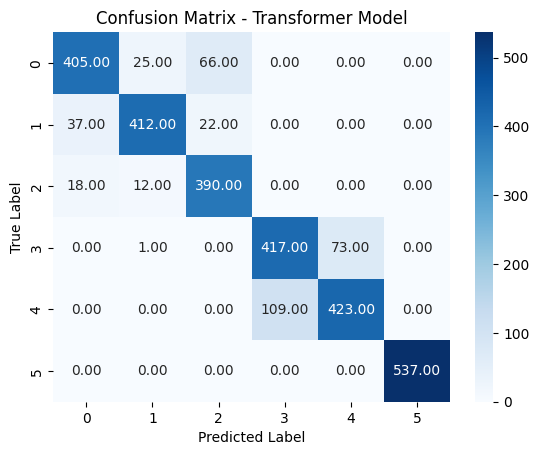

In [7]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

pred = transformer_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print("Confusion Matrix:")
print(cm)
print(f"\nAccuracy: {accuracy_score(testy, pred):.4f}")
print("\nClassification Report:")
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix - Transformer Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
